In [1]:
import sklearn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
plt.rcParams["figure.figsize"] = (15,5)

# Air passengers analysis

Data downloaded from [Kaggle](https://www.kaggle.com/rakannimer/air-passengers)

## Load data

In [8]:
df = pd.read_csv("./Data/AirPassengers.csv", parse_dates=["Month"])
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## Check for missing values

In [9]:
df.isnull().value_counts()

Month  #Passengers
False  False          144
dtype: int64

## Set the date as an index

In [10]:
df = df.set_index('Month')

## Plot the data

<AxesSubplot:xlabel='Month'>

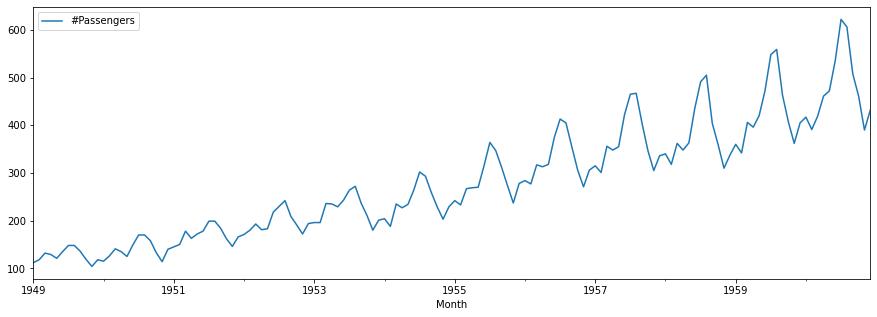

In [11]:
df.plot()

# Stationarity

## ADF Analysis
[Docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

Time series is not stationary because the PValue is more than 5% (0.05), it's 0.99

In [14]:
adf, pvalue, _,_,critical_values,_ = adfuller(df)
adf, pvalue, critical_values

(0.8153688792060433,
 0.9918802434376409,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598})

**Note:** if pvalue < 5%, adv < critical_values[5%]

## Make the time series stationary

### Differenciating to reduce the P value
- First order differentiation

In [15]:
diffed_df = diff(df)

<AxesSubplot:xlabel='Month'>

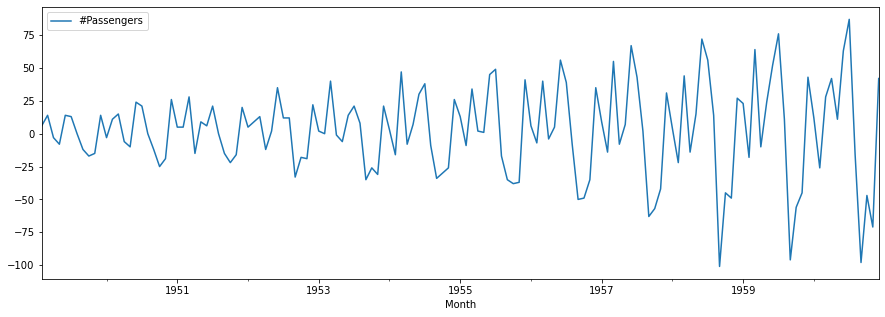

In [16]:
diffed_df.plot()

<AxesSubplot:xlabel='Month'>

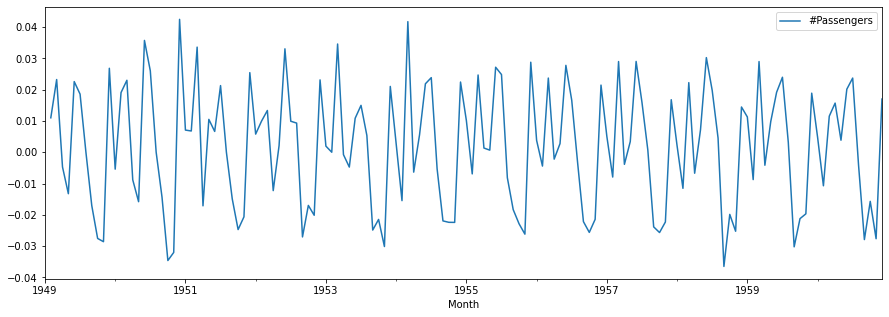

In [17]:
np.log(np.log(df)).diff().plot()

In [18]:
df_without_exponential_growth = np.log(df)
df_log_1_diff = diff(df_without_exponential_growth)

In [19]:
adfuller(df_log_1_diff)

(-2.717130598388118,
 0.07112054815086118,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -440.35846985568105)

This error is created by the nans created by df.diff, you can either dropna or use the statsmodels diff to avoid it.

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

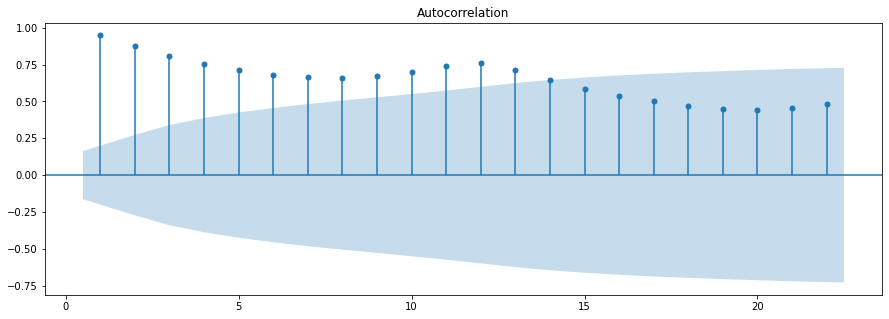

In [21]:
_ = plot_acf(df, zero=False)

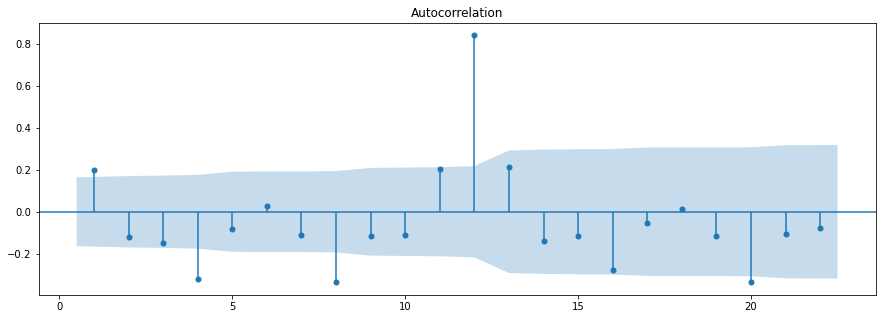

In [22]:
_ = plot_acf(df_log_1_diff, zero=False)

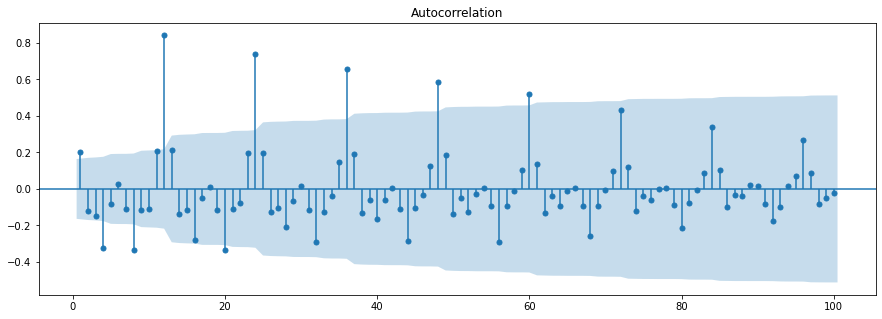

In [23]:
_ = plot_acf(df_log_1_diff, zero=False, lags=100)

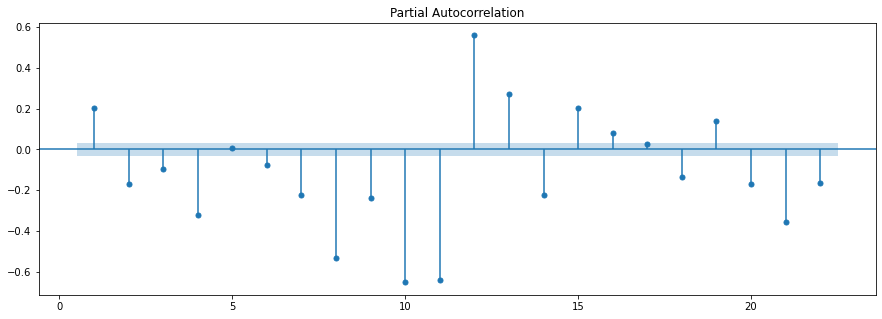

In [25]:
_ = plot_pacf(df_log_1_diff, zero=False, alpha=0.7) # 0.05

### Determine if the process is AR

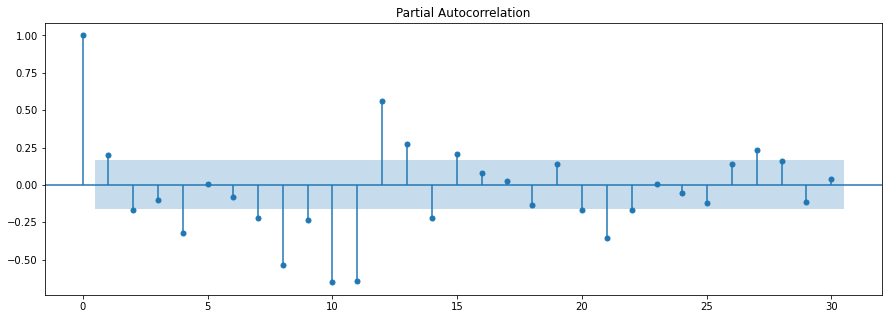

In [26]:
_ = plot_pacf(df_log_1_diff, lags=30)

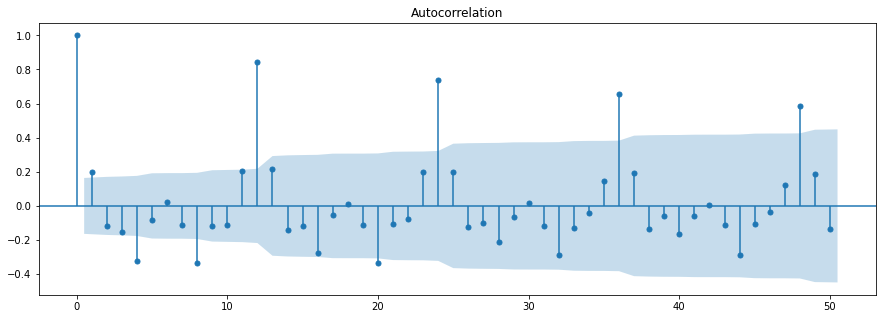

In [27]:
_ = plot_acf(df_log_1_diff, lags=50)

The process seems to be ARMA

### Split the data 

In [28]:
df_log_1_diff.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01',
               '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01',
               '1949-10-01', '1949-11-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=143, freq=None)

In [29]:
from sklearn.model_selection import train_test_split


# train_df = df_log_1_diff[df_log_1_diff["month"] < np.datetime64("1954-12-31")]

# Split the dataset into training and test datasets
# train_df, test_df = train_test_split(df_log_1_diff, test_size=0.2, random_state=42)


train_df = df_log_1_diff[ : '1957-12-01'].copy()
test_df = df_log_1_diff['1957-12-01': ].copy()
# df_log_1_diff.where(df_log_1_diff.index < np.datetime64("1957-12-01"))



In [30]:
train_df.head()

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


In [31]:
test_df.index

DatetimeIndex(['1957-12-01', '1958-01-01', '1958-02-01', '1958-03-01',
               '1958-04-01', '1958-05-01', '1958-06-01', '1958-07-01',
               '1958-08-01', '1958-09-01', '1958-10-01', '1958-11-01',
               '1958-12-01', '1959-01-01', '1959-02-01', '1959-03-01',
               '1959-04-01', '1959-05-01', '1959-06-01', '1959-07-01',
               '1959-08-01', '1959-09-01', '1959-10-01', '1959-11-01',
               '1959-12-01', '1960-01-01', '1960-02-01', '1960-03-01',
               '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01',
               '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01',
               '1960-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [74]:
from statsmodels.tsa.arima.model import ARIMA
import time

def train_model(train_data, order, model_type):
    mod = ARIMA(train_data, order=order)
    
    start_time = time.time()
    fitted_model = mod.fit()
    fit_time = time.time() - start_time


    print(fitted_model.summary())

    plt.plot(fitted_model.fittedvalues, color = "blue")
    plt.plot(train_data["#Passengers"], color = "orange")
    plt.title(f"{model_type} model, train data (orange), fitted values (blue)")
    plt.show()

    residuals = train_data["#Passengers"] - fitted_model.fittedvalues
    plt.plot(residuals)
    plt.title(f"{model_type} model, residuals")
    plt.show()

    return fitted_model, fit_time

In [79]:
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_model(model, test_data, model_type, fit_time):
    y_true = test_df["#Passengers"]
    y_pred = model.predict(start=test_df.index[0], end=test_df.index[-1])
    
    metrics = {}
    metrics[model_type] = {}
    metrics[model_type]["MAPE"] =  mean_absolute_percentage_error(test_df["#Passengers"], y_pred)
    metrics[model_type]["AIC"] =  model.aic
    metrics[model_type]["BIC"] =  model.bic
    metrics[model_type]["fit_time"] =  fit_time
    print(f"MAPE score: {metrics[model_type]['MAPE']}")
    print(f"AIC score: {metrics[model_type]['AIC']}")
    print(f"BIC score: {metrics[model_type]['BIC']}")
    print(f"Fit time: {metrics[model_type]['fit_time']}")
    print()

    plt.plot(y_pred, color = "blue")
    plt.plot(y_true, color = "orange")
    plt.title(f"{model_type} model, test data (orange), predicted values (blue)")
    plt.show()

    return metrics

C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\si

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  107
Model:                ARIMA(13, 0, 0)   Log Likelihood                 181.289
Date:                Sat, 31 Jul 2021   AIC                           -332.579
Time:                        02:33:46   BIC                           -292.486
Sample:                    02-01-1949   HQIC                          -316.326
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0103      0.003      3.235      0.001       0.004       0.016
ar.L1         -0.4029      0.086     -4.703      0.000      -0.571      -0.235
ar.L2         -0.1204      0.082     -1.475      0.1

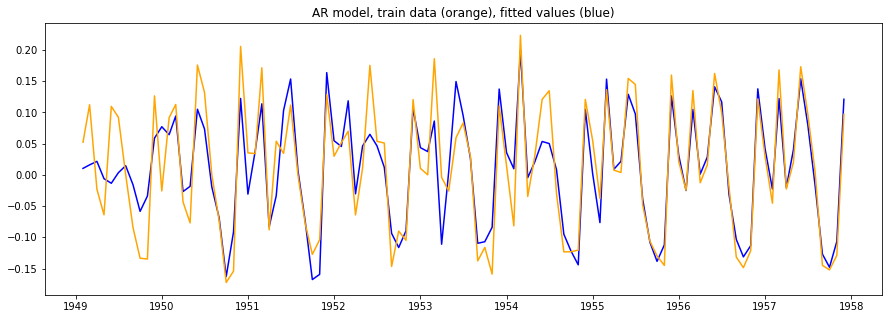

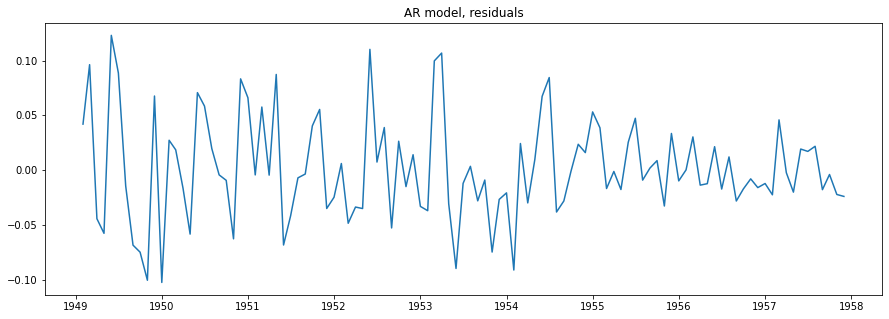

In [75]:
ar_model, ar_fit_time = train_model(train_df, (13, 0, 0), "AR")

C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


MAPE score: 0.5068919680704362
AIC score: -332.5785285938854
BIC score: -292.4860960769568
Fit time: 1.3048298358917236



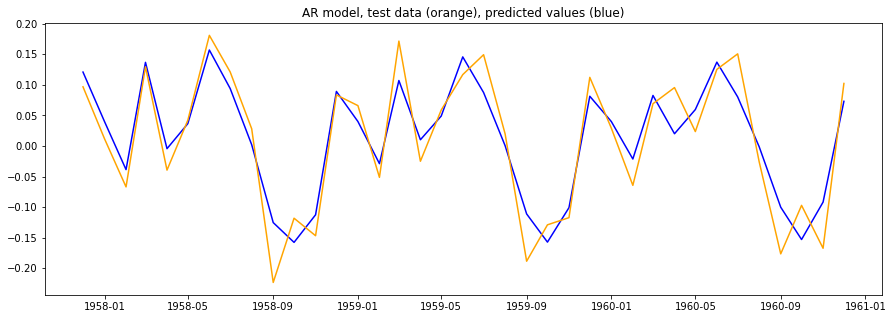

In [80]:
ar_metrics = evaluate_model(ar_model, test_df, "AR", ar_fit_time)


C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  107
Model:                ARIMA(0, 0, 60)   Log Likelihood                 187.390
Date:                Sat, 31 Jul 2021   AIC                           -250.779
Time:                        02:36:43   BIC                            -85.064
Sample:                    02-01-1949   HQIC                          -183.600
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.002      4.583      0.000       0.006       0.015
ma.L1         -0.1575      0.769     -0.205      0.838      -1.665       1.350
ma.L2         -0.1556      1.053     -0.148      0.8

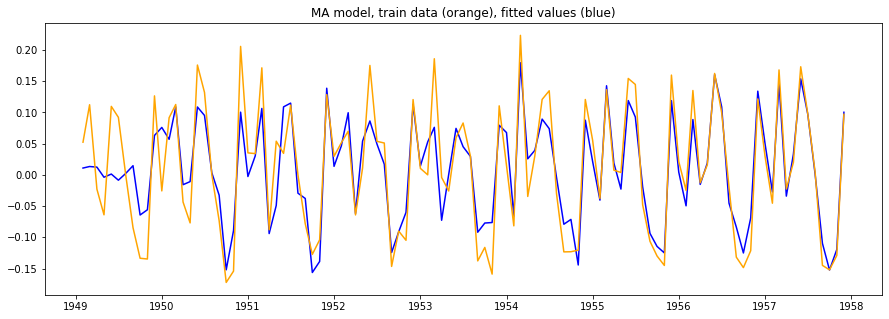

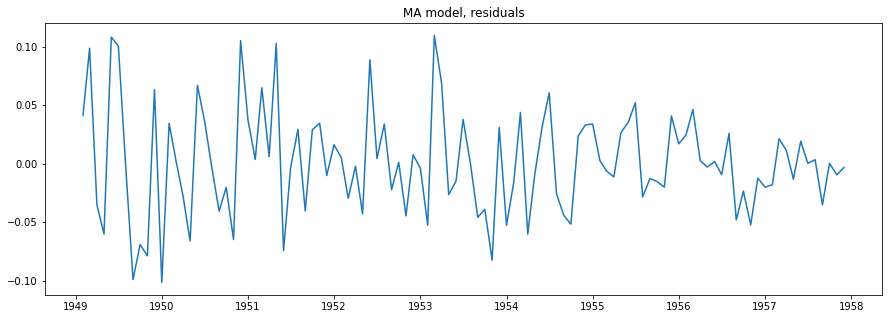

In [81]:
ma_model, ma_fit_time = train_model(train_df, (0, 0, 60), "MA")

C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


MAPE score: 0.6009993144968816
AIC score: -250.7791645271285
BIC score: -85.06377679049035
Fit time: 36.569483280181885



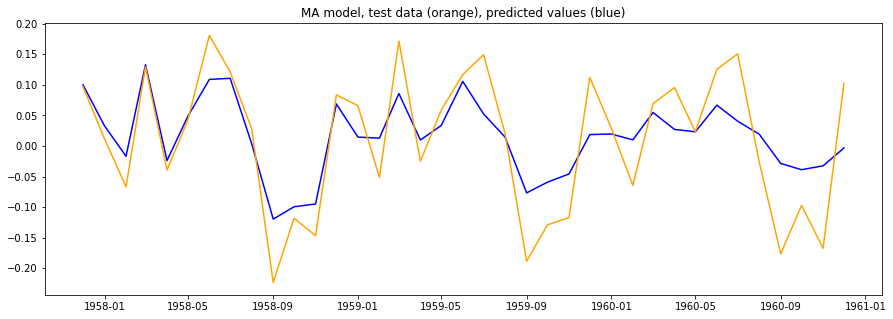

In [82]:
ma_metrics = evaluate_model(ma_model, test_df, "MA", ma_fit_time)

C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  107
Model:               ARIMA(13, 0, 60)   Log Likelihood                 193.855
Date:                Sat, 31 Jul 2021   AIC                           -237.710
Time:                        02:37:34   BIC                            -37.248
Sample:                    02-01-1949   HQIC                          -156.446
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.002      4.858      0.000       0.006       0.015
ar.L1         -0.3042      9.085     -0.033      0.973     -18.110      17.502
ar.L2         -0.1125      8.411     -0.013      0.9

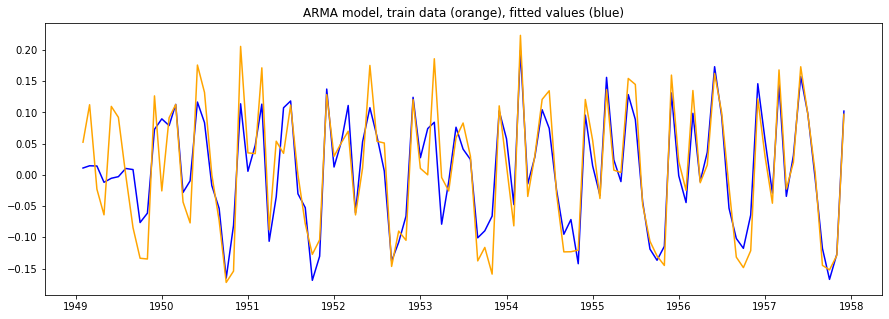

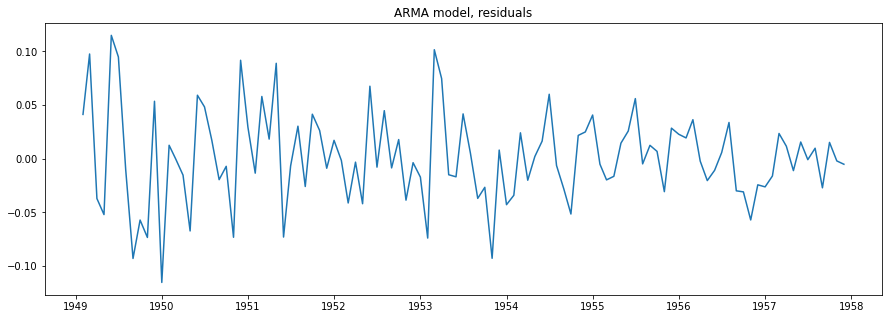

C:\Users\jumpe\.conda\envs\ML_EPITA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


MAPE score: 0.5109649736053417
AIC score: -237.71020149411964
BIC score: -37.24803890947669
Fit time: 49.35570740699768



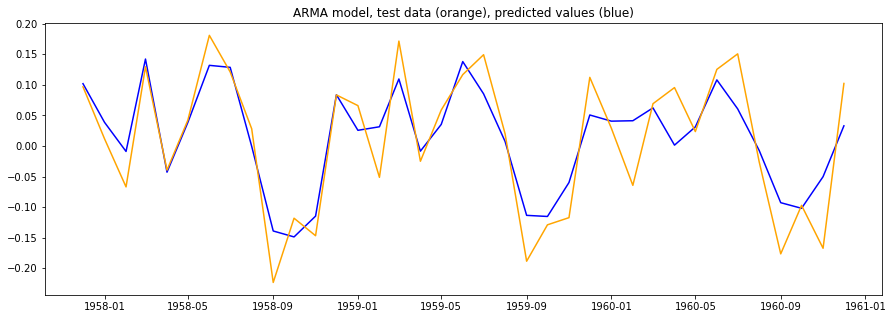

In [83]:
arma_model, arma_fit_time = train_model(train_df, (13, 0, 60), "ARMA")
arma_metrics = evaluate_model(arma_model, test_df, "ARMA", arma_fit_time)



In [84]:
all_results = {**ar_metrics, **ma_metrics, **arma_metrics}
all_results


{'AR': {'MAPE': 0.5068919680704362,
  'AIC': -332.5785285938854,
  'BIC': -292.4860960769568,
  'fit_time': 1.3048298358917236},
 'MA': {'MAPE': 0.6009993144968816,
  'AIC': -250.7791645271285,
  'BIC': -85.06377679049035,
  'fit_time': 36.569483280181885},
 'ARMA': {'MAPE': 0.5109649736053417,
  'AIC': -237.71020149411964,
  'BIC': -37.24803890947669,
  'fit_time': 49.35570740699768}}

In [85]:
models = []
values = []
for key, value in all_results.items():
    models.append(key)
    values.append(value)

values_df = pd.DataFrame(values, index=models)
values_df.head(6)

,MAPE,AIC,BIC,fit_time
AR,0.506892,-332.578529,-292.486096,1.304830
MA,0.600999,-250.779165,-85.063777,36.569483
ARMA,0.510965,-237.710201,-37.248039,49.355707


Text(0.5, 1.0, 'AIC/BIC comparisson')

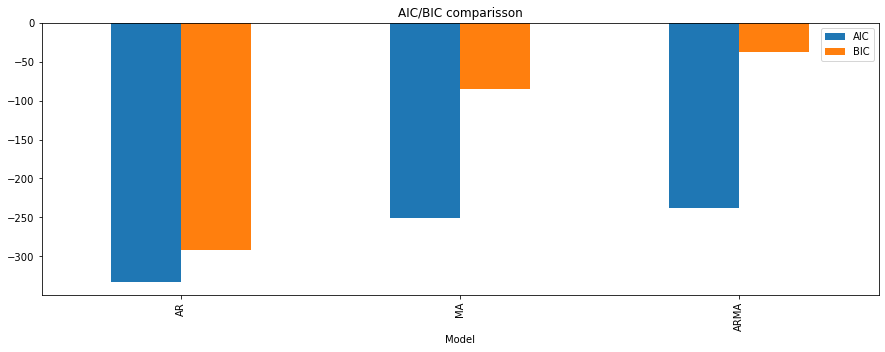

In [86]:
values_df.plot(y=['AIC', 'BIC'], kind="bar")
plt.xlabel("Model")
plt.title("AIC/BIC comparisson")

Text(0.5, 1.0, 'MAPE comparisson')

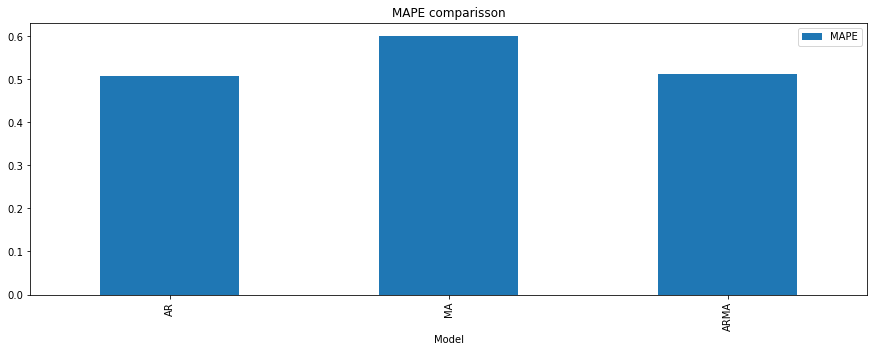

In [87]:
values_df.plot(y=['MAPE'], kind="bar")
plt.xlabel("Model")
plt.title("MAPE comparisson")

Text(0.5, 1.0, 'Fit time comparisson (seconds)')

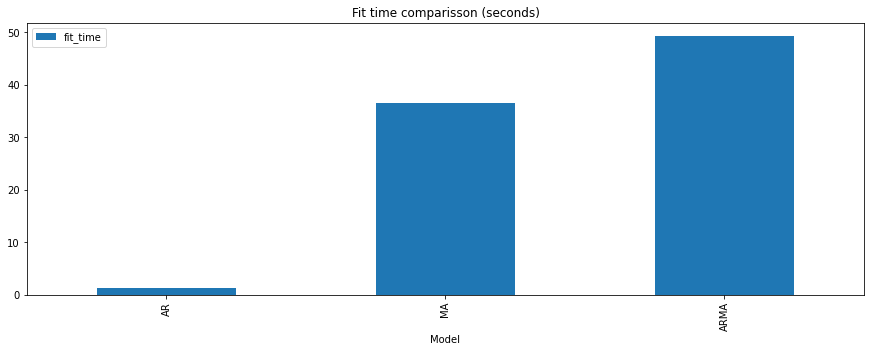

In [89]:
values_df.plot(y=['fit_time'], kind="bar")
plt.xlabel("Model")
plt.title("Fit time comparisson (seconds)")